# Regularization and Fairness

#### Import required libraries and functions.

In [1]:
#Standard ibraries for EDA and operations.
import numpy as np
import pandas as pd

#Standard libraries for visualisations.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Useful for displaying notes in jupyter notebooks
from IPython.display import Markdown, display

#Models and metrics
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import RandomizedSearchCV

#Time related measurements and operaitions.
import time 

#AIF360 data, metrics, functions and classes.
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric

#AIF360 tools for optimised pre-processing (of input data)
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult, get_distortion_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

#### Download datasets and save in local directories described within the package's README
This is different for those running in google colab.

In [2]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -P /Users/adenrelekomolafe/opt/anaconda3/lib/python3.7/site-packages/aif360/data/raw/adult
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names -P /Users/adenrelekomolafe/opt/anaconda3/lib/python3.7/site-packages/aif360/data/raw/adult
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -P /Users/adenrelekomolafe/opt/anaconda3/lib/python3.7/site-packages/aif360/data/raw/adult

#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data -P /Users/adenrelekomolafe/opt/anaconda3/lib/python3.7/site-packages/aif360/data/raw/german
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc -P /Users/adenrelekomolafe/opt/anaconda3/lib/python3.7/site-packages/aif360/data/raw/german

#### Import the pre-processed Adult and German datasets

##### Retain multiple sensitive attributes

In [3]:
#Adult dataset retaining protected attributes
adult_dataset = load_preproc_data_adult(['sex', 'race'])

#German dataset retaining protected attributes
german_dataset = load_preproc_data_german(['sex', 'age'])

#### Split into train and test sets
Note, standard scaler is not used below but is used within the function created for 5-fold validation and for the chosen models.

In [4]:
#Adult
train, test = adult_dataset.split([0.7], shuffle=True, seed=0)

#German
ger_train, ger_test = german_dataset.split([0.7], shuffle=True, seed=0)

#### Define privileged and unprivileged groups

In [5]:
#Intersectionality of identities!
privileged_adult = [{'sex': 1, 'race': 1}]
unprivileged_adult = [{'sex': 0, 'race': 0}]

privileged_german = [{'sex': 1, 'age': 1}]
unprivileged_german = [{'sex': 0, 'age': 0}]

#### Description of the training sets

In [6]:
display(Markdown("#### Adult training set shape"))
print(train.features.shape)
display(Markdown("#### Adult training set labels"))
print(f"{train.label_names, train.favorable_label, train.unfavorable_label}: Above or below 50K")
display(Markdown("#### Adult training set feature names"))
print(train.feature_names)

display(Markdown("#### German dataset training set shape"))
print(ger_train.features.shape)
display(Markdown("#### German training set label names"))
print(f"{ger_train.label_names, ger_train.favorable_label, ger_train.unfavorable_label}: Good or bad credit")
display(Markdown("#### German training set feature names"))
print(ger_train.feature_names)

#### Adult training set shape

(34189, 18)


#### Adult training set labels

(['Income Binary'], 1.0, 0.0): Above or below 50K


#### Adult training set feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### German dataset training set shape

(700, 11)


#### German training set label names

(['credit'], 1.0, 2.0): Good or bad credit


#### German training set feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


#### Measure bias within the datasets

In [7]:
adult_train_metrics = BinaryLabelDatasetMetric(train,privileged_groups=privileged_adult, unprivileged_groups=unprivileged_adult)
adult_test_metrics = BinaryLabelDatasetMetric(test,privileged_groups=privileged_adult, unprivileged_groups=unprivileged_adult)

ger_train_metrics = BinaryLabelDatasetMetric(ger_train,privileged_groups=privileged_german, unprivileged_groups=unprivileged_german)
ger_test_metrics = BinaryLabelDatasetMetric(ger_test,privileged_groups=privileged_german, unprivileged_groups=unprivileged_german)

adult_train_stat_par_diff = adult_train_metrics.statistical_parity_difference()
adult_test_stat_par_diff = adult_test_metrics.statistical_parity_difference()

ger_train_stat_par_diff = ger_train_metrics.statistical_parity_difference()
ger_test_stat_par_diff = ger_test_metrics.statistical_parity_difference()

display(Markdown("#### Statistical parity difference before any processing or model development"))
print(f"Statistical parity difference in the adult dataset train split is {adult_train_stat_par_diff.round(3)}.")
print(f"Statistical parity difference in the german dataset train split is {ger_train_stat_par_diff.round(3)}.")

#### Statistical parity difference before any processing or model development

Statistical parity difference in the adult dataset train split is -0.243.
Statistical parity difference in the german dataset train split is -0.251.


#### Create a function to complete five fold validation using multiple values of C with Support Vector Machines (SVM)

In [8]:
def Accuracy_Fairness_eval(reg_param_list, train_data, privileged_group, unprivileged_group):

    #This dictionary will store C values as keys and scores/metrics as values. Will be returned by the function.
    param_and_scores = {}

    #Time taken will be measures to view impact of dataset size on speed of SVM.
    time_list = []

    #5 folds for 5 fold validation
    fold1, fold2, fold3, fold4, fold5 = train_data.split(5)
    list_of_folds = (fold1, fold2, fold3, fold4, fold5)
    
    #Used to normalise the data.
    scale = StandardScaler()

    list_of_fold_labels = (fold1.labels.ravel(), fold2.labels.ravel(), fold3.labels.ravel(), fold4.labels.ravel(), fold5.labels.ravel())
    list_of_scaled_fold_features = (scale.fit_transform(fold1.features), scale.fit_transform(fold2.features), scale.fit_transform(fold3.features), scale.fit_transform(fold4.features), scale.fit_transform(fold5.features))
    
    
    #Loop for each value of C.
    for reg_param in reg_param_list:
        clf = svm.SVC(kernel="rbf", C= reg_param)
            
        param_and_scores[reg_param] = {}
        scores = {}
        scores['accuracy']= []
        scores['f1_score']=[]
        scores['statistical_parity_difference']=[] 
        scores['disparate_impact']= [] 
        scores['error_rate_ratio'] = []

        for i, item in enumerate(list_of_folds):
            if i ==0:
                fold_test, train_fold_features, train_fold_labels = list_of_folds[i], np.concatenate(list_of_scaled_fold_features[i+1:]), np.concatenate(list_of_fold_labels[i+1:])
                test_features = scale.transform(fold_test.features)

            elif i == max(range(len(list_of_folds))):
                fold_test, train_fold_features, train_fold_labels  = list_of_folds[i], np.concatenate(list_of_scaled_fold_features[:i]), np.concatenate(list_of_fold_labels[:i])
                test_features = scale.transform(fold_test.features)

            else:
                fold_test, train_fold_features = list_of_folds[i], np.concatenate([np.concatenate(list_of_scaled_fold_features[:i]), np.concatenate(list_of_scaled_fold_features[i+1:])])
                train_fold_labels = np.concatenate([np.concatenate(list_of_fold_labels[:i]), np.concatenate(list_of_fold_labels[i+1:])])
                test_features = scale.transform(fold_test.features)

            start_time = time.time()
            
            clf.fit(train_fold_features, train_fold_labels)
            y_pred = clf.predict(test_features)

            end_time = time.time() # Time taken is measured to show impact of data size on svm performace/speed.
            time_taken = end_time - start_time
            time_list.append(time_taken)

            test_pred = fold_test.copy()
            test_pred.labels = y_pred
            
            f1 = f1_score(y_true=fold_test.labels, y_pred=y_pred)
            
            fairness_metrics = ClassificationMetric(fold_test, test_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
            scores['accuracy'].append(fairness_metrics.accuracy())
            scores['f1_score'].append(f1)
            scores['error_rate_ratio'].append(fairness_metrics.error_rate_ratio())  #unprivileged error rate / privilged error rate   
            scores['statistical_parity_difference'].append(fairness_metrics.statistical_parity_difference())
            scores['disparate_impact'].append(fairness_metrics.disparate_impact()) #want this close to 1.

        
        scores['accuracy']= np.mean(scores['accuracy'])
        scores['f1_score'] = np.mean(scores['f1_score'])
        scores['statistical_parity_difference']=np.mean(scores['statistical_parity_difference'])
        scores['disparate_impact']= np.mean(scores['disparate_impact'])
        scores['error_rate_ratio'] = np.mean(scores['error_rate_ratio'])
        param_and_scores[reg_param] = scores
    
    #Return mean scores/metrics and mean time taken for each fold.
    return (param_and_scores, time_list)  

#### German and Adult dataset accuracy and fairness evaluation.

In [9]:
C = (0.001, 0.01, 0.1, 1, 10, 100, 1000)

#Adult
adult_SVM = Accuracy_Fairness_eval(
                                C, 
                                train_data= train, 
                                privileged_group=privileged_adult, 
                                unprivileged_group = unprivileged_adult
)

#German
ger_SVM = Accuracy_Fairness_eval(
                                C, 
                                train_data= ger_train, 
                                privileged_group= privileged_german, 
                                unprivileged_group = unprivileged_german
)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


#### View mean time taken for fit and predict per fold

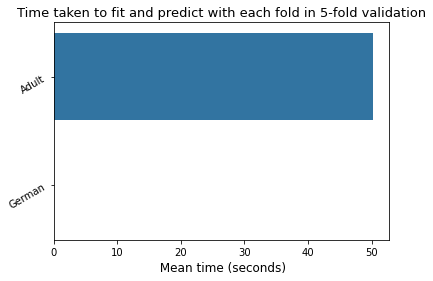

In [10]:
datasets = ["Adult", "German"]
times = [np.mean(adult_SVM[1]), np.mean(ger_SVM[1])]

fig, ax = plt.subplots()
p1 = sns.barplot(y=datasets, x=times)
plt.title("Time taken to fit and predict with each fold in 5-fold validation", fontsize = 13)
plt.xlabel(" Mean time (seconds)", fontsize = 12)

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.yticks(rotation = 30)

plt.savefig('Time taken per fold')

In [11]:
display(Markdown("#### Mean time taken per fold"))
print(f"Adult: {round(np.mean(adult_SVM[1]),2)}")
print(f"German: {round(np.mean(ger_SVM[1]),2)}")

#### Mean time taken per fold

Adult: 50.18
German: 0.02


#### Preview data obtained from 5-fold validation

In [12]:
adult_SVM[0][1]

{'accuracy': 0.8038258057950172,
 'f1_score': 0.48909875249117213,
 'statistical_parity_difference': -0.23039424959253446,
 'disparate_impact': 0.0,
 'error_rate_ratio': 0.298152889776646}

#### Convert dictionaries/data to pandas dataframes and explore

In [13]:
adult_SVM_df = pd.DataFrame(adult_SVM[0])
adult_SVM_df = adult_SVM_df.swapaxes('index', 'columns')
adult_SVM_df = adult_SVM_df.reset_index()
adult_SVM_df = adult_SVM_df.rename(columns={'index': 'regularisation_parameter'})
adult_SVM_df['dataset'] = 'Adult'

ger_SVM_df = pd.DataFrame(ger_SVM[0])
ger_SVM_df = ger_SVM_df.swapaxes('index', 'columns')
ger_SVM_df = ger_SVM_df.reset_index()
ger_SVM_df = ger_SVM_df.rename(columns={'index': 'regularisation_parameter'})
ger_SVM_df['dataset'] = 'German'

frames = (adult_SVM_df, ger_SVM_df)
adult_ger_df = pd.concat(frames)
adult_ger_df = adult_ger_df.reset_index(drop=True)
adult_ger_df['Processing'] = 'None'
adult_ger_df['err_rate_ratio_absolute_dist_to_1'] = abs(1 - adult_ger_df.error_rate_ratio)

In [14]:
most_acc_question_one_by_set = adult_ger_df[['regularisation_parameter','dataset' ,'accuracy', 'f1_score']].groupby(by=['regularisation_parameter', 'dataset']).mean().sort_values(by='accuracy', ascending=False)
most_acc_question_one_by_set = most_acc_question_one_by_set.reset_index( )
most_acc_question_one_by_set

,regularisation_parameter,dataset,accuracy,f1_score
0,1.000,Adult,0.803826,0.489099
1,100.000,Adult,0.803387,0.494237
2,0.100,Adult,0.803036,0.489893
3,1000.000,Adult,0.802919,0.497160
4,10.000,Adult,0.802831,0.492555
5,0.010,Adult,0.797069,0.467770
6,0.001,Adult,0.759425,0.000000
7,1.000,German,0.710000,0.821485
8,10.000,German,0.704286,0.813382
9,0.001,German,0.700000,0.822747


In [15]:
#This function displays values in seaborn barplots.
#Code adapted from https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

#### Plot results

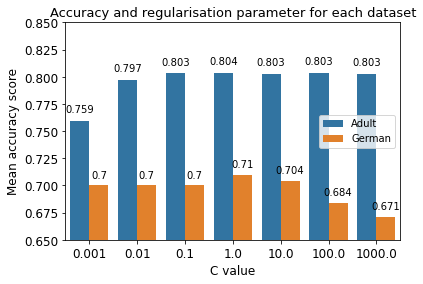

In [16]:
fig = plt.figure()
p1 = sns.barplot(
                x = most_acc_question_one_by_set.regularisation_parameter, 
                y=most_acc_question_one_by_set.accuracy, 
                hue = most_acc_question_one_by_set.dataset
)

plt.ylim((0.65, 0.85))
plt.title("Accuracy and regularisation parameter for each dataset", fontsize = 13)
plt.xlabel("C value", fontsize =12)
plt.ylabel("Mean accuracy score", fontsize =12)
plt.legend(loc = 5)
show_values(p1)
fig.savefig('Q1 accuracy per dataset.jpg', bbox_inches='tight', dpi=150)

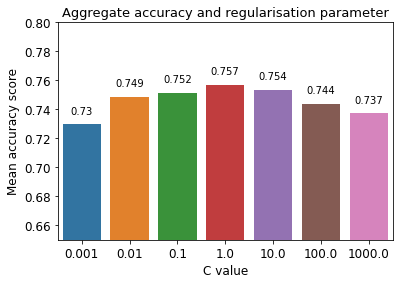

In [17]:
grouped_q1_most_acc = adult_ger_df[[
                                    'regularisation_parameter',
                                    'dataset' ,
                                    'accuracy', 
                                    'f1_score'
                                    ]]
                                    
grouped_q1_most_acc = grouped_q1_most_acc.groupby(by=['regularisation_parameter']).mean().sort_values(by='accuracy', ascending=False)
grouped_q1_most_acc = grouped_q1_most_acc.reset_index()

p2 = sns.barplot(
                x = grouped_q1_most_acc.regularisation_parameter, 
                y=grouped_q1_most_acc.accuracy
)

plt.ylim((0.65, 0.8))
plt.title("Aggregate accuracy and regularisation parameter", fontsize =13)
plt.xlabel("C value", fontsize = 12)
plt.ylabel("Mean accuracy score", fontsize = 12)
show_values(p2)
plt.savefig('aggregate accuracy q1', bbox_inches='tight', dpi=150)

In [18]:
#Order data by absolute distance to 1 of the ERR to select the most fair.
adult_ger_df.groupby(by=['regularisation_parameter', 'dataset']).mean().sort_values(by='err_rate_ratio_absolute_dist_to_1', ascending=True).round(3)

,,accuracy,f1_score,statistical_parity_difference,disparate_impact,error_rate_ratio,err_rate_ratio_absolute_dist_to_1
regularisation_parameter,dataset,,,,,,
1000.000,German,0.671,0.780,-0.462,0.506,1.373,0.373
100.000,German,0.684,0.795,-0.508,0.473,1.423,0.423
10.000,German,0.704,0.813,-0.503,0.489,1.508,0.508
1.000,German,0.710,0.821,-0.531,0.468,1.686,0.686
100.000,Adult,0.803,0.494,-0.237,0.006,0.303,0.697
1000.000,Adult,0.803,0.497,-0.242,0.005,0.302,0.698
1.000,Adult,0.804,0.489,-0.230,0.000,0.298,0.702
0.100,Adult,0.803,0.490,-0.224,0.000,0.298,0.702
10.000,Adult,0.803,0.493,-0.237,0.002,0.298,0.702


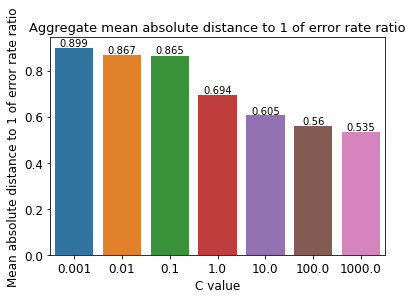

In [19]:
q1_most_fair = adult_ger_df[[
                            'regularisation_parameter', 
                            'dataset', 'err_rate_ratio_absolute_dist_to_1', 
                            'error_rate_ratio', 
                            'disparate_impact', 
                            'statistical_parity_difference'
                            ]]
                            
q1_most_fair = q1_most_fair.groupby(by=['regularisation_parameter']).mean().sort_values(by='err_rate_ratio_absolute_dist_to_1', ascending=True)
q1_most_fair = q1_most_fair.round(3).reset_index()

p3 = sns.barplot(
                x = q1_most_fair.regularisation_parameter, 
                y=q1_most_fair.err_rate_ratio_absolute_dist_to_1
)

plt.title("Aggregate mean absolute distance to 1 of error rate ratio", fontsize =13)
plt.xlabel("C value", fontsize = 12)
plt.ylabel("Mean absolute distance to 1 of error rate ratio", fontsize = 12)
show_values(p3)
plt.savefig('Aggregate fairness q1', bbox_inches='tight', dpi=150)


#### Create a function to build and evaluate the chosen models using the train and test sets (most fair and most accurate)

In [20]:
def model_chosen(c_value, train_data, test_data, privileged_group, unprivileged_group, gamma="scale"):

    scale = StandardScaler()
    X_train = scale.fit_transform(train_data.features)
    Y_train = train_data.labels.ravel()
    
    X_test = scale.transform(test_data.features)
    

    clf = svm.SVC(C=c_value, kernel='rbf', gamma=gamma)
    clf.fit(X_train, Y_train)

    y_pred = clf.predict(X_test)

    test_pred = test_data.copy()
    test_pred.labels = y_pred
                
    f1 = f1_score(y_true=test_data.labels, y_pred=y_pred)
                
    fairness_metrics = ClassificationMetric(test_data, test_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    scores = {}
    scores['f1'] = f1
    scores['accuracy'] = fairness_metrics.accuracy()
    scores['error rate ratio'] = fairness_metrics.error_rate_ratio() 
    scores['stat par diff'] = fairness_metrics.statistical_parity_difference()
    scores['disparat_impact'] = fairness_metrics.disparate_impact()
    return scores

In [21]:
adult_most_accurate = model_chosen(c_value=1, train_data=train, test_data=test, privileged_group=privileged_adult, unprivileged_group=unprivileged_adult)

In [22]:
display(Markdown("#### Most accurate model using the Adult dataset."))
print("The accuracy score in the adult dataset of the final model chosen for accuracy is: {}.".format(adult_most_accurate['accuracy'].round(3)))
print("The F1 score in the adult dataset of the final model chosen for accuracy is: {}.".format(adult_most_accurate['f1'].round(3)))

#### Most accurate model using the Adult dataset.

The accuracy score in the adult dataset of the final model chosen for accuracy is: 0.804.
The F1 score in the adult dataset of the final model chosen for accuracy is: 0.473.


In [23]:
display(Markdown("#### Most accurate model using the German dataset."))
ger_most_accurate = model_chosen(c_value=1, train_data=ger_train, test_data=ger_test, privileged_group=privileged_german, unprivileged_group=unprivileged_german)
print("The accuracy score in the german dataset of the final model chosen for accuracy is: {}.".format(ger_most_accurate['accuracy'].round(3)))
print("The F1 score in the german dataset of the final model chosen for accuracy is: {}.".format(ger_most_accurate['f1'].round(3)))

#### Most accurate model using the German dataset.

The accuracy score in the german dataset of the final model chosen for accuracy is: 0.693.
The F1 score in the german dataset of the final model chosen for accuracy is: 0.815.


#### Dataframe of the results

In [24]:
final_adult_accuracy_df = pd.DataFrame(adult_most_accurate, index = [0])
final_adult_accuracy_df['dataset'] = 'Adult'

final_german_accuracy_df = pd.DataFrame(ger_most_accurate, index = [1])
final_german_accuracy_df['dataset'] = 'German'

final_accurates_df = pd.concat((final_adult_accuracy_df, final_german_accuracy_df))
final_accurates_df

,f1,accuracy,error rate ratio,stat par diff,disparat_impact,dataset
0,0.473453,0.803726,0.274701,-0.214654,0.000000,Adult
1,0.815261,0.693333,0.661962,-0.318105,0.676976,German


In [25]:
adult_most_fair = model_chosen(
                                c_value=1000, 
                                train_data=train, 
                                test_data=test, 
                                privileged_group=privileged_adult, 
                                unprivileged_group=unprivileged_adult
)

ger_most_fair = model_chosen(
                            c_value=1000, 
                            train_data=ger_train, 
                            test_data=ger_test, 
                            privileged_group=privileged_german, 
                            unprivileged_group=unprivileged_german
)

In [26]:
final_adult_fair_df = pd.DataFrame(adult_most_fair, index = [0])
final_adult_fair_df['dataset'] = 'Adult'

final_german_fair_df = pd.DataFrame(ger_most_fair, index = [1])
final_german_fair_df['dataset'] = 'German'

final_fair_df = pd.concat((final_adult_fair_df, final_german_fair_df))
final_fair_df['err_rate_ratio_absolute_dist_to_1'] = abs(1-final_fair_df['error rate ratio'])
final_fair_df.round(3)

,f1,accuracy,error rate ratio,stat par diff,disparat_impact,dataset,err_rate_ratio_absolute_dist_to_1
0,0.479,0.804,0.275,-0.220,0.000,Adult,0.725
1,0.808,0.687,0.912,-0.396,0.595,German,0.088


### Optimised Preprocessing

In [27]:
adult_optim_options = {
    "distortion_fun": get_distortion_adult,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}
    
adult_OP = OptimPreproc(
                        OptTools,
                        adult_optim_options, 
                        unprivileged_groups= {'sex': 0, 'race': 0}, 
                        privileged_groups = {'sex': 1, 'race': 1}, 
                        seed = 0
)

adult_OP = adult_OP.fit(train)
adult_transf_train = adult_OP.transform(train, transform_Y=True)
adult_transf_train = train.align_datasets(adult_transf_train)

adult_trans_train_metrics = BinaryLabelDatasetMetric(
                                                    adult_transf_train,
                                                    privileged_groups=privileged_adult, 
                                                    unprivileged_groups=unprivileged_adult
)

adult_transf_stat_par = adult_trans_train_metrics.statistical_parity_difference()

diff_after_transformation = abs(adult_train_stat_par_diff - adult_transf_stat_par)
diff_percentage_stat_par = diff_after_transformation*100/abs(adult_train_stat_par_diff)

ger_optim_options = {
    "distortion_fun": get_distortion_german,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}
    
ger_OP = OptimPreproc(
                        OptTools, 
                        ger_optim_options, 
                        unprivileged_groups= {'sex': 0, 'age': 0}, 
                        privileged_groups = {'sex': 1, 'age': 1}, 
                        seed = 0
)

ger_OP = ger_OP.fit(ger_train)
ger_transf_train = ger_OP.transform(ger_train, transform_Y=True)
ger_transf_train = ger_train.align_datasets(ger_transf_train)

ger_trans_train_metrics = BinaryLabelDatasetMetric(
                                                    ger_transf_train,
                                                    privileged_groups=privileged_german, 
                                                    unprivileged_groups=unprivileged_german
)

ger_transf_stat_par = ger_trans_train_metrics.statistical_parity_difference()

ger_diff_after_transformation = abs(ger_train_stat_par_diff - ger_transf_stat_par)
ger_diff_percentage_stat_par = ger_diff_after_transformation*100/abs(ger_train_stat_par_diff)

Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.

This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 

Optimized Preprocessing: Objective converged to 0.014187


Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.

This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 

Optimized Preprocessing: Objective converged to 0.001794


#### Measure View bias within data after optimised pre-processing

In [28]:
display(Markdown("#### New statistical parity values within transformed datasets:"))
print(f"Statistical parity difference in the transformed Adult dataset train split is {adult_transf_stat_par.round(3)}.")
print(f"This is a fabourable increase from ({adult_train_stat_par_diff.round(3)}) of {diff_percentage_stat_par.round()}%.")

print(f"Statistical parity difference in the transformed German dataset train split is {ger_transf_stat_par.round(3)}.")
print(f"This is a fabourable increase from ({ger_train_stat_par_diff.round(3)}) of {ger_diff_percentage_stat_par.round()}%.")

#### New statistical parity values within transformed datasets:

Statistical parity difference in the transformed Adult dataset train split is -0.048.
This is a fabourable increase from (-0.243) of 80.0%.
Statistical parity difference in the transformed German dataset train split is -0.044.
This is a fabourable increase from (-0.251) of 82.0%.


#### Cross validate using transformed train splits and visualise (dataframes and plots)

In [29]:
adult_after_OptP = Accuracy_Fairness_eval(
                                        C, 
                                        adult_transf_train, 
                                        unprivileged_group=unprivileged_adult, 
                                        privileged_group=privileged_adult
)

ger_after_OptP = Accuracy_Fairness_eval(
                                        C, 
                                        ger_transf_train, 
                                        unprivileged_group=unprivileged_german, 
                                        privileged_group=privileged_german
)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


In [30]:
adult_OptP_df = pd.DataFrame(adult_after_OptP[0])
adult_OptP_df = adult_OptP_df.swapaxes('index', 'columns')
adult_OptP_df = adult_OptP_df.reset_index()
adult_OptP_df = adult_OptP_df.rename(columns={'index': 'regularisation_parameter'})
adult_OptP_df['dataset'] = 'Adult'

ger_OptP_df = pd.DataFrame(ger_after_OptP[0])
ger_OptP_df = ger_OptP_df.swapaxes('index', 'columns')
ger_OptP_df = ger_OptP_df.reset_index()
ger_OptP_df = ger_OptP_df.rename(columns={'index': 'regularisation_parameter'})
ger_OptP_df['dataset'] = 'German'

OptP_frames = (adult_OptP_df, ger_OptP_df)
adult_ger_OptP_df = pd.concat(OptP_frames)
adult_ger_OptP_df = adult_ger_OptP_df.reset_index(drop=True)
adult_ger_OptP_df['Processing'] = 'Optimised Preprocessing'
adult_ger_OptP_df['err_rate_ratio_absolute_dist_to_1'] = abs(1 - abs(adult_ger_OptP_df.error_rate_ratio))

In [31]:
OptP_most_acc = adult_ger_OptP_df[['regularisation_parameter','dataset' ,'accuracy', 'f1_score']].groupby(by=['regularisation_parameter', 'dataset']).mean().sort_values(by='accuracy', ascending=False).reset_index()
OptP_most_acc.round(4)

,regularisation_parameter,dataset,accuracy,f1_score
0,1.000,Adult,0.7793,0.5036
1,10.000,Adult,0.7789,0.5068
2,100.000,Adult,0.7785,0.5054
3,1000.000,Adult,0.7778,0.5052
4,0.100,Adult,0.7774,0.5069
5,0.010,Adult,0.7758,0.4754
6,0.001,Adult,0.7463,0.0000
7,0.001,German,0.7071,0.8277
8,0.010,German,0.7071,0.8277
9,0.100,German,0.7071,0.8277


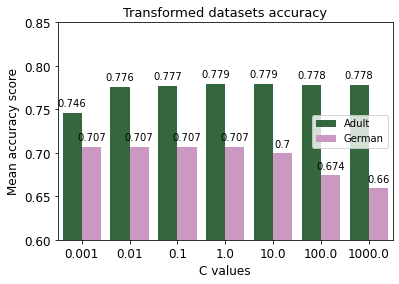

In [32]:
p4 = sns.barplot(
                x=OptP_most_acc.regularisation_parameter, 
                y=OptP_most_acc.accuracy, hue=OptP_most_acc.dataset,
                palette=("cubehelix")
)

plt.ylim((0.6,0.85))
show_values(p4)
plt.legend(loc = 5)
plt.title("Transformed datasets accuracy", fontsize =13)
plt.xlabel("C values", fontsize=12)
plt.ylabel("Mean accuracy score", fontsize =12)
plt.savefig('Q2 accuracy', bbox_inches='tight', dpi=150)

In [33]:
whole_adult_OP = adult_OP.fit(adult_dataset)
whole_adult_transformed = adult_OP.transform(adult_dataset, transform_Y=True)
whole_adult_transformed = adult_dataset.align_datasets(whole_adult_transformed)
transformed_adult_train, transformed_adult_test = whole_adult_transformed.split([0.7], shuffle=True, seed=0)

whole_german_OP = ger_OP.fit(german_dataset)
whole_german_transformed = ger_OP.transform(german_dataset, transform_Y=True)
whole_german_transformed = german_dataset.align_datasets(whole_german_transformed)
transformed_german_train, transformed_german_test = whole_german_transformed.split([0.7], shuffle=True, seed=0)


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use 

Optimized Preprocessing: Objective converged to 0.014939



This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 13 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 14 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use

Optimized Preprocessing: Objective converged to 0.000000


#### Select the most dair and most accurate models using the datasets

In [34]:
OptP_chosen_adult_accuracy = model_chosen(
                                            c_value=1,
                                            train_data=transformed_adult_train,
                                            test_data=transformed_adult_test,
                                            privileged_group=privileged_adult,
                                            unprivileged_group=unprivileged_adult,
)

OptP_chosen_german_accuracy = model_chosen(
                                            c_value=1,
                                            train_data=transformed_german_train,
                                            test_data=transformed_german_test,
                                            privileged_group=privileged_german,
                                            unprivileged_group=unprivileged_german,
)

In [35]:
OptP_chosen_adult_accuracy.items()

dict_items([('f1', 0.5005433938829373), ('accuracy', 0.7804545144339043), ('error rate ratio', 0.9624765478424011), ('stat par diff', -0.17473069299694688), ('disparat_impact', 0.19288857329111564)])

In [36]:
OptP_chosen_german_accuracy.items()

dict_items([('f1', 0.8212180746561885), ('accuracy', 0.6966666666666667), ('error rate ratio', 0.6619623655913979), ('stat par diff', 0.015228426395939132), ('disparat_impact', 1.0154639175257731)])

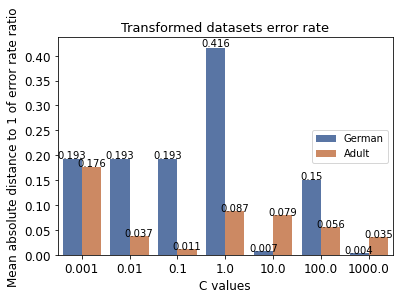

In [37]:
OptP_most_fair = adult_ger_OptP_df[[
                                    'regularisation_parameter',
                                    'dataset' ,
                                    'err_rate_ratio_absolute_dist_to_1', 
                                    'error_rate_ratio', 
                                    'statistical_parity_difference'
                                    ]]
                                    
OptP_most_fair = OptP_most_fair.groupby(by=['regularisation_parameter', 'dataset']).mean().sort_values(by='err_rate_ratio_absolute_dist_to_1')
OptP_most_fair = OptP_most_fair.round(3).reset_index()

p5 = sns.barplot(
                x=OptP_most_fair.regularisation_parameter, 
                y=OptP_most_fair.err_rate_ratio_absolute_dist_to_1, 
                hue=OptP_most_fair.dataset,
                palette=("deep")
)

show_values(p5)
plt.legend(loc = 5)
plt.title("Transformed datasets error rate", fontsize =13)
plt.xlabel("C values", fontsize=12)
plt.ylabel("Mean absolute distance to 1 of error rate ratio", fontsize =12)
plt.savefig('Q2 fair', bbox_inches='tight', dpi=150)

In [38]:
OptP_most_fair

,regularisation_parameter,dataset,err_rate_ratio_absolute_dist_to_1,error_rate_ratio,statistical_parity_difference
0,1000.000,German,0.004,0.996,-0.344
1,10.000,German,0.007,1.007,-0.439
2,0.100,Adult,0.011,0.989,-0.124
3,1000.000,Adult,0.035,0.965,-0.173
4,0.010,Adult,0.037,0.963,-0.133
5,100.000,Adult,0.056,0.944,-0.179
6,10.000,Adult,0.079,0.921,-0.186
7,1.000,Adult,0.087,0.913,-0.190
8,100.000,German,0.150,1.150,-0.448
9,0.001,Adult,0.176,0.824,0.000


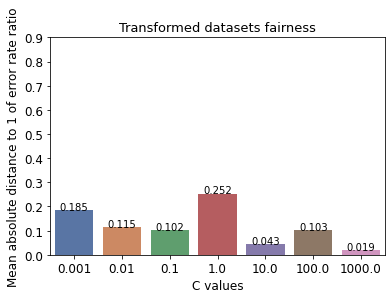

In [39]:
agg_fair_OptP = adult_ger_OptP_df[[
                                    'regularisation_parameter',
                                    'dataset' ,
                                    'err_rate_ratio_absolute_dist_to_1', 
                                    'error_rate_ratio', 
                                    'statistical_parity_difference'
                                    ]]
                                    
agg_fair_OptP = agg_fair_OptP.groupby(by=['regularisation_parameter']).mean().sort_values(by='err_rate_ratio_absolute_dist_to_1')
agg_fair_OptP = agg_fair_OptP.round(3).reset_index()

p6 = sns.barplot(
                x=agg_fair_OptP.regularisation_parameter, 
                y=agg_fair_OptP.err_rate_ratio_absolute_dist_to_1, 
                palette=("deep")
)
show_values(p6)
plt.title("Transformed datasets fairness", fontsize =13)
plt.xlabel("C values", fontsize=12)
plt.ylabel("Mean absolute distance to 1 of error rate ratio", fontsize =12)
plt.ylim((0,0.9))
plt.savefig('Q2 fair aggregated', bbox_inches='tight', dpi=150)

In [40]:
OptP_chosen_adult_fair = model_chosen(
                                            c_value=1000,
                                            train_data=transformed_adult_train,
                                            test_data=transformed_adult_test,
                                            privileged_group=privileged_adult,
                                            unprivileged_group=unprivileged_adult,
)

OptP_chosen_german_fair = model_chosen(
                                            c_value=1000,
                                            train_data=transformed_german_train,
                                            test_data=transformed_german_test,
                                            privileged_group=privileged_german,
                                            unprivileged_group=unprivileged_german,
)

In [41]:
OptP_chosen_adult_fair.items()

dict_items([('f1', 0.5017043693833283), ('accuracy', 0.7805227598444004), ('error rate ratio', 0.985864135864136), ('stat par diff', -0.1625281151596941), ('disparat_impact', 0.24885654885654887)])

In [42]:
OptP_chosen_german_fair.items()

dict_items([('f1', 0.8112449799196787), ('accuracy', 0.6866666666666666), ('error rate ratio', 0.7817460317460319), ('stat par diff', -0.10469543147208127), ('disparat_impact', 0.8931347150259067)])

#### Convert all results into a pandas datafram for visualisation and analysis

In [43]:
all_frames = (adult_ger_df, adult_ger_OptP_df)
all_df = adult_ger_OptP_df = pd.concat(all_frames)
all_df_accuracy = all_df[[
                            'regularisation_parameter',
                            'dataset' ,
                            'accuracy', 
                            'f1_score', 
                            'Processing'
                            ]]
all_df_accuracy = all_df_accuracy.groupby(by=['regularisation_parameter', 'dataset', 'Processing']).mean().sort_values(by='accuracy', ascending=False).reset_index()

In [44]:
all_df_fairness = all_df[[
                            'err_rate_ratio_absolute_dist_to_1', 
                            'error_rate_ratio', 
                            'statistical_parity_difference',
                            'regularisation_parameter', 
                            'dataset', 
                            'Processing'
                            ]]
all_df_fairness = all_df_fairness.groupby(by=['regularisation_parameter', 'dataset', 'Processing'])
all_df_fairness = all_df_fairness.mean().sort_values(by='err_rate_ratio_absolute_dist_to_1', ascending=True).reset_index()

Text(0, 0.5, 'Mean absolute distance to 1 of ERR')

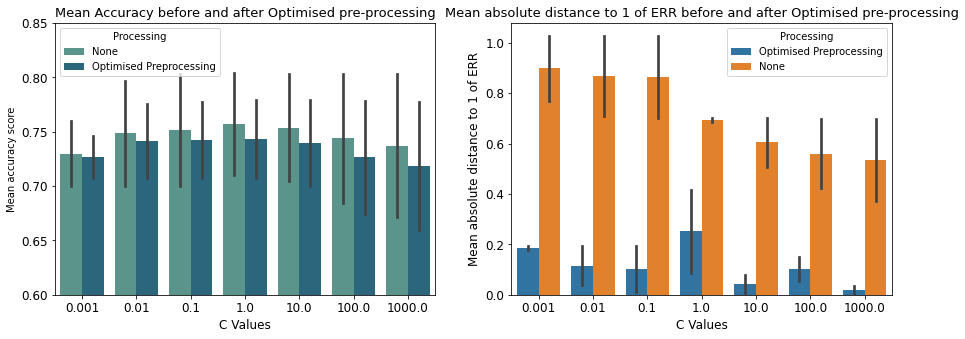

In [45]:
fig, axs = plt.subplots(ncols=2, figsize = [15,5])

sns.barplot(x= all_df_accuracy.regularisation_parameter, y = all_df_accuracy.accuracy, hue=all_df_accuracy.Processing, ax = axs[0], palette='crest')
axs[0].set_ylim((0.6,0.85))
axs[0].set_title('Mean Accuracy before and after Optimised pre-processing', fontsize =13)
axs[0].set_xlabel('C Values', fontsize = 12)
axs[0].set_ylabel('Mean accuracy score')


axs[1].set_title('Mean absolute distance to 1 of ERR before and after Optimised pre-processing', fontsize =13)
sns.barplot(x= all_df_fairness.regularisation_parameter, y = all_df_fairness.err_rate_ratio_absolute_dist_to_1 , hue=all_df_fairness.Processing, ax = axs[1])
axs[1].set_xlabel('C Values', fontsize = 12)
axs[1].set_ylabel('Mean absolute distance to 1 of ERR', fontsize = 12)

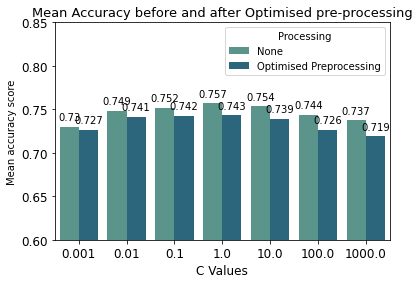

In [46]:
p7 = sns.barplot(x= all_df_accuracy.regularisation_parameter, y = all_df_accuracy.accuracy, hue=all_df_accuracy.Processing, ci=None, palette='crest')
plt.ylim((0.6,0.85))
plt.title('Mean Accuracy before and after Optimised pre-processing', fontsize =13)
plt.xlabel('C Values', fontsize = 12)
plt.ylabel('Mean accuracy score')
show_values(p7)
plt.savefig('Before and after OptP', bbox_inches='tight', dpi=150)

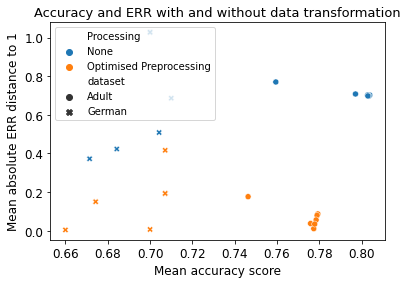

In [47]:
sns.scatterplot(
    x=all_df.accuracy, 
    y=all_df.err_rate_ratio_absolute_dist_to_1, 
    hue=all_df.Processing, style=all_df.dataset
    )
plt.legend(loc=2)
plt.xlabel("Mean accuracy score", fontsize = 12)
plt.ylabel("Mean absolute ERR distance to 1", fontsize = 12)
plt.title("Accuracy and ERR with and without data transformation", fontsize = 13)
plt.savefig('Q3 Accuracy and ERR with and without data transformation', bbox_inches='tight', dpi=150)

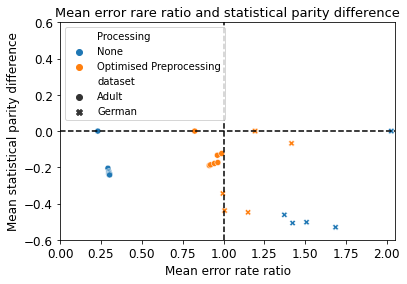

In [48]:
sns.scatterplot(
    x=all_df.error_rate_ratio,
    y=all_df['statistical_parity_difference'], 
    hue=all_df.Processing, 
    style=all_df.dataset
    )
plt.legend(loc=2)
plt.xlabel("Mean error rate ratio", fontsize = 12)
plt.ylabel("Mean statistical parity difference", fontsize = 12)
plt.title("Mean error rare ratio and statistical parity difference", fontsize = 13)
plt.ylim((-0.6,0.6))
plt.xlim((0,2.05))
plt.hlines(y=0, xmin = 0, xmax=3, linestyle = '--', color = 'black')
plt.vlines(x=1, ymin = -0.6, ymax=0.6, linestyle = '--', color = 'black')
plt.savefig('ERR and SPD coss', bbox_inches='tight', dpi=150)

In [49]:
all_df_fairness.round(3).to_excel("most fair table.xlsx")
all_df_fairness.round(3)

,regularisation_parameter,dataset,Processing,err_rate_ratio_absolute_dist_to_1,error_rate_ratio,statistical_parity_difference
0,1000.000,German,Optimised Preprocessing,0.004,0.996,-0.344
1,10.000,German,Optimised Preprocessing,0.007,1.007,-0.439
2,0.100,Adult,Optimised Preprocessing,0.011,0.989,-0.124
3,1000.000,Adult,Optimised Preprocessing,0.035,0.965,-0.173
4,0.010,Adult,Optimised Preprocessing,0.037,0.963,-0.133
5,100.000,Adult,Optimised Preprocessing,0.056,0.944,-0.179
6,10.000,Adult,Optimised Preprocessing,0.079,0.921,-0.186
7,1.000,Adult,Optimised Preprocessing,0.087,0.913,-0.190
8,100.000,German,Optimised Preprocessing,0.150,1.150,-0.448
9,0.001,Adult,Optimised Preprocessing,0.176,0.824,0.000


#### Model Selection Strategy
Optimise the chosen models for accuracy using the RadomisedCV function provided in SciKitlearn 

In [50]:
parameter_dict_one = {
                        'C':[1],
                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
                        'kernel':['rbf']
}

parameter_dict_thousand = {
                        'C':[1000],
                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
                        'kernel':['rbf']
}

svm_model = svm.SVC(gamma='auto')

In [51]:
scale = StandardScaler()

RSCV_adult_features = scale.fit_transform(transformed_adult_train.features)
RSCV_adult_labels = transformed_adult_train.labels.ravel()

RSCV_German_features = scale.fit_transform(transformed_german_train.features)
RSCV_German_labels = transformed_german_train.labels.ravel()

In [52]:
rf_grid_one_adult = RandomizedSearchCV(estimator=svm_model,param_distributions=parameter_dict_one, cv=5, verbose=2, n_jobs=-1)

rf_grid_one_adult.fit(RSCV_adult_features, RSCV_adult_labels)
rf_grid_one_adult.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.3min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.3min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.1min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END ...................

{'kernel': 'rbf', 'gamma': 1, 'C': 1}

In [53]:
rf_grid_one_ger = RandomizedSearchCV(estimator=svm_model,param_distributions=parameter_dict_one, cv=5, verbose=2, n_jobs=-1)
rf_grid_one_ger.fit(RSCV_German_features, RSCV_German_labels)
rf_grid_one_ger.best_params_

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=0.01,

{'kernel': 'rbf', 'gamma': 0.01, 'C': 1}

In [54]:
rf_grid_thousand_adult = RandomizedSearchCV(estimator=svm_model,param_distributions=parameter_dict_thousand, cv=5, verbose=2, n_jobs=-1)
rf_grid_thousand_adult.fit(RSCV_adult_features, RSCV_adult_labels)
rf_grid_thousand_adult.best_params_


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 1.3min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time= 1.3min
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time= 1.9min
[CV] END .....................C=1000, gamma=0.01,

{'kernel': 'rbf', 'gamma': 1, 'C': 1000}

In [55]:
rf_grid_thousand_ger = RandomizedSearchCV(estimator=svm_model,param_distributions=parameter_dict_thousand, cv=5, verbose=2, n_jobs=-1)
rf_grid_thousand_ger.fit(RSCV_German_features, RSCV_German_labels)
rf_grid_thousand_ger.best_params_

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=1000, gamma=0.01,

{'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}

#### Build models using the "best" parameters for gamma and evaluate results

In [56]:
selection_strategy_accurate_adult = model_chosen(
                                                c_value=1, 
                                                train_data= transformed_adult_train, 
                                                test_data=transformed_adult_test,
                                                privileged_group=privileged_adult,
                                                unprivileged_group=unprivileged_adult,
                                                gamma=1
                                                )

In [57]:
selection_strategy_accurate_german = model_chosen(
                                                c_value=1, 
                                                train_data= transformed_german_train, 
                                                test_data=transformed_german_test,
                                                privileged_group=privileged_german,
                                                unprivileged_group=unprivileged_german,
                                                gamma=0.01
                                                )

In [58]:
selection_strategy_fair_adult = model_chosen(
                                                c_value=1000, 
                                                train_data= transformed_adult_train, 
                                                test_data=transformed_adult_test,
                                                privileged_group=privileged_adult,
                                                unprivileged_group=unprivileged_adult,
                                                gamma=1
                                                )

In [59]:
selection_strategy_fair_german = model_chosen(
                                                c_value=1000, 
                                                train_data= transformed_german_train, 
                                                test_data=transformed_german_test,
                                                privileged_group=privileged_german,
                                                unprivileged_group=unprivileged_german,
                                                gamma=0.001
                                                )

In [60]:
selection_strategy_accurate_adult.items()

dict_items([('f1', 0.5008533747090768), ('accuracy', 0.7804545144339043), ('error rate ratio', 0.985864135864136), ('stat par diff', -0.17131932395090288), ('disparat_impact', 0.20822690822690823)])

In [61]:
selection_strategy_accurate_german.items()

dict_items([('f1', 0.828125), ('accuracy', 0.7066666666666667), ('error rate ratio', 0.6956214689265537), ('stat par diff', 0.0), ('disparat_impact', 1.0)])

In [62]:
selection_strategy_fair_adult.items()

dict_items([('f1', 0.5008533747090768), ('accuracy', 0.7804545144339043), ('error rate ratio', 0.985864135864136), ('stat par diff', -0.17131932395090288), ('disparat_impact', 0.20822690822690823)])

In [63]:
selection_strategy_fair_german.items()

dict_items([('f1', 0.8134920634920635), ('accuracy', 0.6866666666666666), ('error rate ratio', 1.0591397849462365), ('stat par diff', -0.19310490693739424), ('disparat_impact', 0.8039089347079038)])